# Strategic Teams

After experimenting with a policy-gradient based leader agent in [Crossing_Leader_PG.ipynb](Crossing_Leader_PG.ipynb), we arrived at the conclusion that RL (policy-gradient or Q-learning) is not effective at strategic decision making. Specifically, we discovered that a drone leader, even with complete observation of the game space, was not able to overcome the problems of local optima and sparce reward.

It is therefore necessary to seperate the behavioral aspect of a team from its strategic decision making.

## Strategist Class

A strategist analyzes the strategic position of the teams of agents it is responsible for directing, based on observable game space and game metrics provided by the Environment. Implemented as a black box, it outputs a Goal for each team.

## Team Class

The Team class has a Mission and a Culture.

A team's Culture is used to shape an agent's behavior regardless of role or type. It does so by adding an "imaginary" behavioral reward/penalty to the reward given to the agent by the environment during training. Doing so shape the agent's policy NN so that it conforms to the cultural behaviors expected by the team.

A team's Mission/Goal converts the strategist's Goal into a "imaginary" mission reward. This mission reward is added to the reward given to an agent by the environment and the team's Culture during training. Doing so shape the agent's policy NN so that it achieves the Goal demanded of the team. 

A team doles out behavioral and mission reward to its agents regardless of type or role so that it can accomplish the Goal set by its strategist.

## Strategist directing multiple Teams

We envision a multi-agent organization whereby:

* A Strategist directs multiple Teams through Tasks/Objectives.

* Each Team is made up of agents of different types (drones and crawlers) and roles (leaders and followers).

* A Team uses its Culture to shape its agents' behaviors by doling out behavorial rewards during training. It uses its Mission to help its agents learn abilities to accomplish individual or group objectives by doling out mission rewards during training.

* In this way, a Strategist that is optimized for strategic decision making can analyze the games space and direct multiple Teams to accomplish more complex and strategic tasks that require more than behavioral skills.

In [1]:
import os
import random
import time
import platform
import torch
import torch.optim as optim
import gym
import numpy as np
import pickle

# This is the Crossing game environment
from xteams_env import CrossingEnv
from xteams_model import *
from interface import *

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

print("Python version: ", platform.python_version())
print("Pytorch version: {}".format(torch.__version__))
print("OpenAI Gym version: {}".format(gym.__version__))

Python version:  3.6.4
Pytorch version: 0.4.1.post2
OpenAI Gym version: 0.9.2


## Strategist Class

(Wikipedia) A strategist is responsible for the formulation and implementation of a strategy. Strategy generally involves setting goals, determining actions to achieve the goals, and mobilizing resources to execute the actions. It describes how the ends (goals) will be achieved by the means (resources).

An agent belonging to the Strategist class performs the following:

(1) It accepts and abdicates responsibilities for directing teams of agents

(2) It receives game space and metrics from the Environment

(3) It analyzes the game space and metrics to arrive at a "strategic position" for its teams. e.g. a topological map and/or a set of game stats

(4) Based on the strategic position, it decides on a set of goals that need to be accomplished

(5) It surveys its teams of agents and their location in the games space

(6) For each goal, it picks the best team and assign it the goal

(7) If necessary, it reorganize the teams and the agents

(8) It measures the effectiveness of the teams in accomplishing the assigned goals, and whether the "strategic position" has improved for its teams


# Play Game with Strategist

For now, the strategist can only direct 1 team with a drone agent. It access the game space through the complete obs space of the drone agent.


In [110]:
"""
We seperate out the models of drone leaders and crawler followers so that we can mix and match trained models
in game plays.
"""

droneleader_PG_models = [
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_coop/t1.5_rp-1.0_300gs/",  # model 1
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac/t1.5_rp-1.0_300gs/",   # model 2 
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac/t2.0_rp-1.0_300gs/",   # model 3  
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac_apples/t2.0_rp-1.0_300gs/",   # model 4
    "models/2T-5L/pac_droneleader/food_d37_river_w1_d25/pac_vs_pac_apples_teamreward/t2.0_rp-1.0_300gs/",   # model 5
    "models/1T-1L/pg_droneleader/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/", # model 6
    "models/1T-1L/pg_droneleader/food_d37_river_w1_d25/pg_droneleader_seed_8/t2.0_rp-1.0_300gs/", # model 7
    "models/1T-1L/pg_droneleader_2000/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/", # model 8
    "models/1T-1L/pg_droneleader_test/food_d37_river_w1_d25/pg_droneleader_seed_7/t2.0_rp-1.0_300gs/", # model 9
]

droneleader_PG_params = [
    {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
    {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 8},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 7},
]

droneleader_fc32_models = [
    "models/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc32_seed_0/t2.0_rp-1.0_300gs/",   # model 1
    "models/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc32_seed_7/t2.0_rp-1.0_300gs/",   # model 2
    "models/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc32_seed_54/t2.0_rp-1.0_300gs/",  # model 3
]

droneleader_fc32_params = [
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 0},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, \
             'game_steps':300, 'seed': 54}
]

droneleader_fc64_models = [
    "models/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_0/t2.0_rp-1.0_300gs/",   # model 1
    "models/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_7/t2.0_rp-1.0_300gs/",   # model 2
    "models/1T-1L/strategist/food_d37_river_w1_d25/droneleaderfc64_seed_54/t2.0_rp-1.0_300gs/",   # model 3
    "models/1T-1L/strategist_big_reward/food_d37_river_w1_d25/droneleaderfc64_seed_7/t2.0_rp-1.0_300gs/",   # model 4
    "models/1T-1L/strategist_big_reward/food_d37_river_w1_d25/droneleaderfc64_seed_54/t2.0_rp-1.0_300gs/",  # model 5
    "models/1T-1L/strategist_big_reward/food_d37_river_w1_d25/droneleaderfc64_seed_80/t2.0_rp-1.0_300gs/",   # model 6 
]

droneleader_fc64_params = [
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 0},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 54},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 54},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':0.5, 'game_steps':300, 'seed': 80},
]

crawler_models = [
    # Agents trained with a static target zone
    'models/1T-10L/followers_static/food_d37/pacifist_follower/tr5.0_t2.0_rp-1.0_300gs_s1/',   # scenario=1
    'models/1T-10L/followers_static/food_d37/pacifist_follower/tr5.0_t2.0_rp-1.0_300gs_s2/',   # scenario=2
    'models/1T-10L/followers_static/food_d37/pacifist_follower/tr5.0_t2.0_rp-1.0_300gs_s3/',   # scenario=3    
    'models/1T-10L/followers_static/food_d37/pacifist_follower/tr5.0_t1.5_rp-1.0_300gs_s1/',   # scenario=4
    'models/1T-10L/followers_static/food_d37/pacifist_follower/tr5.0_t1.5_rp-1.0_300gs_s2/',   # scenario=5
    'models/1T-10L/followers_static/food_d37/pacifist_follower/tr5.0_t1.5_rp-1.0_300gs_s3/',   # scenario=6
    # Agents trained with a moving target zone, map = food_d37
    "models/1T-10L/followers_trajectory/food_d37/pacifist_follower/tr5.0_t2.0_rp-1.0_600gs_s1/",   # scenario=7
    "models/1T-10L/followers_trajectory/food_d37/pacifist_follower/tr5.0_t2.0_rp-1.0_500gs_s2/",   # scenario=8 
    "models/1T-10L/followers_trajectory/food_d37/pacifist_follower/tr5.0_t1.5_rp-1.0_600gs_s1/",   # scenario=9
    "models/1T-10L/followers_trajectory/food_d37/pacifist_follower/tr5.0_t1.5_rp-1.0_500gs_s2/",   # scenario=10 
    # Agents trained using moving target zone and map = food_d37_river_w1_d25
    "models/1T-10L/followers_trajectory/food_d37_river_w1_d25/pacifist_follower/tr5.0_t1.5_rp-1.0_600gs_s1/",   # scenario=11
    "models/1T-10L/followers_trajectory/food_d37_river_w1_d25/pacifist_follower/tr5.0_t1.5_rp-1.0_500gs_s2/",   # scenario=12
    "models/1T-10L/followers_trajectory/food_d37_river_w1_d25/pacifist_follower/tr5.0_t2.0_rp-1.0_600gs_s1/",   # scenario=13
    "models/1T-10L/followers_trajectory/food_d37_river_w1_d25/pacifist_follower/tr5.0_t2.0_rp-1.0_500gs_s2/",   # scenario=14
    
    # Agents trained with DroneLeader_FC64 
    "models/1T-6L/strategist/food_d37_river_w1_d25/crawler_followers_seed_7/t2.0_tr1.0_300gs/",   # model 15
    "models/1T-6L/strategist/food_d37_river_w1_d25/crawler_followers_seed_7/t2.0_tr2.0_300gs/",   # model 16
    "models/1T-6L/strategist/food_d37_river_w1_d25/crawler_followers_seed_7/t2.0_tr5.0_300gs/",   # model 17
    "models/1T-6L/strategist/food_d37_river_w1_d25/crawler_followers_seed_54/t2.0_tr1.0_300gs/",   # model 18
    "models/1T-6L/strategist/food_d37_river_w1_d25/crawler_followers_seed_54/t2.0_tr2.0_300gs/",   # model 19
    "models/1T-6L/strategist/food_d37_river_w1_d25/crawler_followers_seed_54/t2.0_tr5.0_300gs/",   # model 20
]

crawler_params = [
    # Agents trained with static or moving trajectories
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':300, 'set': 1},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':300, 'set': 2},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':300, 'set': 3},
    {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':300, 'set': 1},
    {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':300, 'set': 2},
    {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':300, 'set': 3},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':600, 'set': 1},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':500, 'set': 2},
    {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':600, 'set': 1},
    {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':500, 'set': 2},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':600, 'set': 1},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':500, 'set': 2},
    {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':600, 'set': 1},
    {'temp_start':1.5, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':500, 'set': 2},
    
    # Agents trained with DroneLeader_FC64   
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':1.0, 'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':300, 'seed': 7},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':1.0, 'game_steps':300, 'seed': 54},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':2.0, 'game_steps':300, 'seed': 54},
    {'temp_start':2.0, 'river_penalty':-1.0, 'target_reward':5.0, 'game_steps':300, 'seed': 54},
]

## PG-based DroneLeader

We implement a DroneLeader using a 3-layer CNN using REINFORCE policy gradient RL algorithm. The drone leader has complete observation of the game space.

we discovered that a drone leader based on very advanced NN with complete observation of the game space, is not able to overcome the problems of local optima and sparce reward. In addition, it learns a very brittle policy of always going back to the same general area of the 1st food pile, even when the map has completely changed (and the food pile is no longer at the same spot). 

In [119]:
from torch.autograd import Variable

game = 'Crossing'

maps = [
    "food_d37_river_w1_d25",
    "food_d37_river_w1_d25_v2",
    "food_d37_river_w1_d25_v3",
    "food_d37_river_w1_d25_v4",
]
starts = [
    (3,9),
    (3,18),
    (20,9),
    (20,18),
    (50,9),
    (50,18),
]

# droneleader_start = starts[random.randint(0,len(starts)-1)]
# map_name = maps[random.randint(0,len(maps)-1)]

map_name = maps[0]
droneleader_start = starts[0]

print("Drone starts at {} in map {}.".format(droneleader_start, map_name))

# device = torch.device('cpu')   # for playing a game on the cpu-only laptop
device = torch.device('cuda')   # for playing a game on the gpu-PC

scenario = 15
dir_name = droneleader_PG_models[scenario-1]
parameter = droneleader_PG_params[scenario-1]
episodes = 400  # This is used to recall a model file trained to a # of episodes

# There will be 1 agents - 1 teams of 1 AI agents each and 0 random agent
num_ai_agents = 1
num_rdn_agents = 0
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two

# Data structure for AI agents (agents will form their own Class later on)
agents = []
actions = []
tags = []

# Set up parameters of agents and teams as inputs into CrossingEnv

# Scenario 26-33
teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},        
]

agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': droneleader_start}
]


# Initialize environment
render = True
SPEED = 1/30
num_crawler_actions = 8                       # Crawlers are capable of 8 actions
num_drone_actions = 12                       # Drones are capable of 12 actions
num_goal_params = 2       # 2 parameters in Goal (delta coordinates)

# Initialize constants
num_frames = 7
max_episodes = 1
max_frames = 100

# Initialize parameters for Crossing and Explore
river_penalty = -1
crossed = [0 for i in range(num_ai_agents)]  # Keep track of agents gathering from 2nd food pile
second_pile_x = 50   # x-coordinate of the 2nd food pile
jumping_zone = True

# Load models for AI agents
if episodes > 0:
    agents= [[] for i in range(num_ai_agents)]
    # If episodes is provided (not 0), load the model for each AI agent
    for i in range(num_ai_agents):
        model_file = dir_name+'MA0_{}_ep{}.p'.format(game,episodes)
        try:
            with open(model_file, 'rb') as f:
                
                print("Load saved model for agent {}".format(i))
                
                # Load agent policy based on type
                if agents_params[i]['type'] is 'crawler':
                    agent = Crawler_Policy(num_frames, num_crawler_actions, i)
                elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'follower':
                    agent = Drone_Policy(num_frames, num_drone_actions, i)
                elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    print("Load Drone Leader.")
                    agent = Drone_Policy(num_frames, num_drone_actions, i)
                else:
                    raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
                    
                optimizer = optim.Adam(agent.parameters(), lr=0.1)

                # New way to save and load models - based on: 
                # https://pytorch.org/tutorials/beginner/saving_loading_models.html
                _ = load_model(agent, optimizer, f, device=device)
                agent.eval()
                agents[i] = agent
        except OSError:
            print('Model file not found.')
            raise
else:
    # If episodes=0, start with a freshly initialized model for each AI agent
    for i in range(num_ai_agents):
        print("Load AI agent {}".format(i))
        if agents_params[i]['type'] is 'drone':
            agents.append(Drone_Policy(num_frames, num_drone_actions, i))
        elif agents_params[i]['type'] is 'crawler':
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
        else:
            raise Exception('Invalid type for agent {}: {}'.format(i,agents_params[i]['type']))

# Load random agents    
for i in range(num_ai_agents,num_agents):
    print("Load random agent {}".format(i))
    agents.append(Rdn_Policy())

# Initialize AI and random agent data
actions = [0 for i in range(num_agents)]
tags = [0 for i in range(num_agents)]

# Attach agents to their teams
# 4-28-2019 Add roles and types to enable multi-role teams

teams = []

# Team Vikings
teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'],culture=teams_params[0]['culture'], \
                  roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:1]]))

# 5-29-2019  Strategist accepts directorship of a team
suntzu = Strategist()
suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking

env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_window = False)   

for ep in range(max_episodes):
    
    US_hits = [0 for i in range(num_agents)]
    THEM_hits = [0 for i in range(num_agents)]

    env_obs = env.reset()  # Environment return observations
    """
    # For Debug only
    print (len(agents_obs))
    print (agents_obs[0].shape)
    """
    
    # Unpack observations into data structure compatible with agent Policy
    agents_obs = unpack_env_obs(env_obs)
    
    # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
    game_space = agents_obs[suntzu.eyes[0].idx]
    goals, topology = suntzu.generate_goals(game_space)
    deltas = calc_deltas(goals[0], env.agent_locations[0])
        
    for i in range(num_ai_agents):    # Reset agent info - e.g. laser tag statistics
        agents[i].reset_info()    
    
    env.render()  
    time.sleep(SPEED)  # Change speed of video rendering
    
    """

    """
    # For Debug only
    # print (len(agents_obs))
    # print (agents_obs[0].shape)    
    
    """
    For now, we do not stack observations, and we do not implement LSTM
    
    state = np.stack([state]*num_frames)

    # Reset LSTM hidden units when episode begins
    cx = Variable(torch.zeros(1, 256))
    hx = Variable(torch.zeros(1, 256))
    """

    for frame in range(max_frames):

        for i in range(num_ai_agents):    # For AI agents
            if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                # PG_based droneleaders requires obs space as input
                actions[i], _ = select_action(agents[i], agents_obs[i], cuda=False)
            else:    
                actions[i], _ = select_action(agents[i], agents_obs[i], cuda=False)
            
            # Only crawlers can fire lasers
            if agents_params[i]['type'] is 'crawler':
                if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                    tags[i] += 1   # record a tag for accessing aggressiveness
                
        for i in range(num_ai_agents, num_agents):   # For random agents
            actions[i] = agents[i].select_action(agents_obs[i])
            if actions[i] is 6:
                tags[i] += 1   # record a tag for accessing aggressiveness
        
        """
        For now, we do not implement LSTM
        # Select action
        action, log_prob, state_value, (hx,cx)  = select_action(model, state, (hx,cx))        
        """

        # if frame % 10 == 0:
        #     print (actions)    
        
        # Perform step        
        env_obs, reward, done, info = env.step(actions)
        
        """
        For Debug only
        print (env_obs)
        print (reward)
        print (done) 
        """

        for i in range(num_ai_agents):
            agents[i].rewards.append(reward[i])  # Stack rewards

        
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)
        load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
        
        # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_deltas(goals[0], env.agent_locations[0])        
        
        for i in range(num_agents):
            # Only crawlers can fire lasers
            if agents_params[i]['type'] is 'crawler':            
                US_hits[i] += agents[i].US_hit
                THEM_hits[i] += agents[i].THEM_hit
            
        """
        For now, we do not stack observation, may come in handy later on
        
        # Evict oldest diff add new diff to state
        next_state = np.stack([next_state]*num_frames)
        next_state[1:, :, :] = state[:-1, :, :]
        state = next_state
        """
        total = 0
        for i in range(num_ai_agents):
            agent_reward = sum(agents[i].rewards)
            total += agent_reward
        
        if render:
            env.render()
            time.sleep(SPEED)  # Change speed of video rendering        

        if any(done):
            print("Done after {} frames".format(frame))
            break

env.close()  # Close the rendering window

# Print out statistics of AI agents

total_rewards = 0
total_tags = 0
total_US_hits = 0
total_THEM_hits = 0

print ('\nStatistics by Agent')
print ('===================')
for i in range(num_ai_agents):
    agent_reward = sum(agents[i].rewards)
    total_rewards += agent_reward
    print ("Agent{} reward is {:d}".format(i, agent_reward))
    
    # Only crawlers can fire lasers
    if agents_params[i]['type'] is 'crawler':     
        agent_tags = sum(agents[i].tag_hist)
        total_tags += agent_tags
        print ("Agent{} aggressiveness is {:.2f}".format(i, sum(agents[i].tag_hist)/(frame+1e-7)))
 
        agent_US_hits = sum(agents[i].US_hits)
        agent_THEM_hits = sum(agents[i].THEM_hits)
        total_US_hits += agent_US_hits
        total_THEM_hits += agent_THEM_hits

        print('US agents hit = {}'.format(agent_US_hits))
        print('THEM agents hit = {}'.format(agent_THEM_hits ))

print ('\nStatistics in Aggregate')
print ('=======================')

# 6-02-2019 Update distance from goal for droneleader
target_x, target_y = goals[0]
current_x, current_y = env.agent_locations[0]
episode_delta = abs(target_x - current_x) + abs(target_y - current_y)
print ('Distance from Goal = {}'.format(episode_delta))

Drone starts at (3, 9) in map food_d37_river_w1_d25.
Load saved model for agent 0
Load Drone Leader.

Statistics by Agent
Agent0 reward is 0

Statistics in Aggregate
Distance from Goal = 44


## Simple DroneLeader_FC32

For DroneLeader_FC32, different manual_seed can result in vastly different policies. For example, manual_seed(54) results in a very adaptable and general policy, while manual_seed(7) performs dismally.

In [46]:
from torch.autograd import Variable

game = 'Crossing'

maps = [
    "food_d37_river_w1_d25",
    "food_d37_river_w1_d25_v2",
    "food_d37_river_w1_d25_v3",
    "food_d37_river_w1_d25_v4",
]
starts = [
    (3,9),
    (3,18),
    (20,9),
    (20,18),
    (50,9),
    (50,18),
]

droneleader_start = starts[random.randint(0,len(starts)-1)]
map_name = maps[random.randint(0,len(maps)-1)]

print("Drone starts at {} in map {}.".format(droneleader_start, map_name))

# device = torch.device('cpu')   # for playing a game on the cpu-only laptop
device = torch.device('cuda')   # for playing a game on the gpu-PC

scenario = 3
dir_name = droneleader_fc32_models[scenario-1]
parameter = droneleader_fc32_params[scenario-1]
episodes = 2000  # This is used to recall a model file trained to a # of episodes

# There will be 1 agents - 1 teams of 1 AI agents each and 0 random agent
num_ai_agents = 1
num_rdn_agents = 0
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two

# Data structure for AI agents (agents will form their own Class later on)
agents = []
actions = []
tags = []

# Set up parameters of agents and teams as inputs into CrossingEnv

# Scenario 26-33
teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},        
]

agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': droneleader_start}
]


# Initialize environment
render = True
SPEED = 1/30
num_crawler_actions = 8                       # Crawlers are capable of 8 actions
num_drone_actions = 12                       # Drones are capable of 12 actions
num_goal_params = 2       # 2 parameters in Goal (delta coordinates)

# Initialize constants
num_frames = 7
max_episodes = 1
max_frames = 100

# Initialize parameters for Crossing and Explore
river_penalty = -1
crossed = [0 for i in range(num_ai_agents)]  # Keep track of agents gathering from 2nd food pile
second_pile_x = 50   # x-coordinate of the 2nd food pile
jumping_zone = True

# Load models for AI agents
if episodes > 0:
    agents= [[] for i in range(num_ai_agents)]
    # If episodes is provided (not 0), load the model for each AI agent
    for i in range(num_ai_agents):
        model_file = dir_name+'MA{}_{}_ep{}.p'.format(i,game,episodes)
        try:
            with open(model_file, 'rb') as f:
                
                print("Load saved model for agent {}".format(i))
                
                # Load agent policy based on type
                if agents_params[i]['type'] is 'crawler':
                    agent = Crawler_Policy(num_frames, num_crawler_actions, i)
                elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'follower':
                    agent = Drone_Policy(num_frames, num_drone_actions, i)
                elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    print("Load Drone Leader.")
                    agent = DroneLeader_FC32(num_goal_params, num_drone_actions, i)
                else:
                    raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
                    
                optimizer = optim.Adam(agent.parameters(), lr=0.1)

                # New way to save and load models - based on: 
                # https://pytorch.org/tutorials/beginner/saving_loading_models.html
                _ = load_model(agent, optimizer, f, device=device)
                agent.eval()
                agents[i] = agent
        except OSError:
            print('Model file not found.')
            raise
else:
    # If episodes=0, start with a freshly initialized model for each AI agent
    for i in range(num_ai_agents):
        print("Load AI agent {}".format(i))
        if agents_params[i]['type'] is 'drone':
            agents.append(Drone_Policy(num_frames, num_drone_actions, i))
        elif agents_params[i]['type'] is 'crawler':
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
        else:
            raise Exception('Invalid type for agent {}: {}'.format(i,agents_params[i]['type']))

# Load random agents    
for i in range(num_ai_agents,num_agents):
    print("Load random agent {}".format(i))
    agents.append(Rdn_Policy())

# Initialize AI and random agent data
actions = [0 for i in range(num_agents)]
tags = [0 for i in range(num_agents)]

# Attach agents to their teams
# 4-28-2019 Add roles and types to enable multi-role teams

teams = []

# Team Vikings
teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'],culture=teams_params[0]['culture'], \
                  roles=teams_params[0]['roles'], \
                  agent_policies=[agents[0]], \
                  agent_roles = [agent['role'] for agent in agents_params[0:1]]))

# 5-29-2019  Strategist accepts directorship of a team
suntzu = Strategist()
suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking

env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_window = False)   

for ep in range(max_episodes):
    
    US_hits = [0 for i in range(num_agents)]
    THEM_hits = [0 for i in range(num_agents)]

    env_obs = env.reset()  # Environment return observations
    """
    # For Debug only
    print (len(agents_obs))
    print (agents_obs[0].shape)
    """
    
    # Unpack observations into data structure compatible with agent Policy
    agents_obs = unpack_env_obs(env_obs)
    
    # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
    game_space = agents_obs[suntzu.eyes[0].idx]
    goals, topology = suntzu.generate_goals(game_space)
    deltas = calc_deltas(goals[0], env.agent_locations[0])
        
    for i in range(num_ai_agents):    # Reset agent info - e.g. laser tag statistics
        agents[i].reset_info()    
    
    env.render()  
    time.sleep(SPEED)  # Change speed of video rendering
    
    """

    """
    # For Debug only
    # print (len(agents_obs))
    # print (agents_obs[0].shape)    
    
    """
    For now, we do not stack observations, and we do not implement LSTM
    
    state = np.stack([state]*num_frames)

    # Reset LSTM hidden units when episode begins
    cx = Variable(torch.zeros(1, 256))
    hx = Variable(torch.zeros(1, 256))
    """

    for frame in range(max_frames):

        for i in range(num_ai_agents):    # For AI agents
            if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                # 6-02-2019 Simple droneleaders do not require obs space as input
                actions[i], _ = select_action_strat_simple(agents[i], deltas, cuda=False)
            else:    
                actions[i], _ = select_action(agents[i], agents_obs[i], cuda=False)
            
            # Only crawlers can fire lasers
            if agents_params[i]['type'] is 'crawler':
                if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                    tags[i] += 1   # record a tag for accessing aggressiveness
                
        for i in range(num_ai_agents, num_agents):   # For random agents
            actions[i] = agents[i].select_action(agents_obs[i])
            if actions[i] is 6:
                tags[i] += 1   # record a tag for accessing aggressiveness
        
        """
        For now, we do not implement LSTM
        # Select action
        action, log_prob, state_value, (hx,cx)  = select_action(model, state, (hx,cx))        
        """

        # if frame % 10 == 0:
        #     print (actions)    
        
        # Perform step        
        env_obs, reward, done, info = env.step(actions)
        
        """
        For Debug only
        print (env_obs)
        print (reward)
        print (done) 
        """

        for i in range(num_ai_agents):
            agents[i].rewards.append(reward[i])  # Stack rewards

        
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)
        load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
        
        # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_deltas(goals[0], env.agent_locations[0])        
        
        for i in range(num_agents):
            # Only crawlers can fire lasers
            if agents_params[i]['type'] is 'crawler':            
                US_hits[i] += agents[i].US_hit
                THEM_hits[i] += agents[i].THEM_hit
            
        """
        For now, we do not stack observation, may come in handy later on
        
        # Evict oldest diff add new diff to state
        next_state = np.stack([next_state]*num_frames)
        next_state[1:, :, :] = state[:-1, :, :]
        state = next_state
        """
        total = 0
        for i in range(num_ai_agents):
            agent_reward = sum(agents[i].rewards)
            total += agent_reward
        
        if render:
            env.render()
            time.sleep(SPEED)  # Change speed of video rendering        

        if any(done):
            print("Done after {} frames".format(frame))
            break

env.close()  # Close the rendering window

# Print out statistics of AI agents

total_rewards = 0
total_tags = 0
total_US_hits = 0
total_THEM_hits = 0

print ('\nStatistics by Agent')
print ('===================')
for i in range(num_ai_agents):
    agent_reward = sum(agents[i].rewards)
    total_rewards += agent_reward
    print ("Agent{} reward is {:d}".format(i, agent_reward))
    
    # Only crawlers can fire lasers
    if agents_params[i]['type'] is 'crawler':     
        agent_tags = sum(agents[i].tag_hist)
        total_tags += agent_tags
        print ("Agent{} aggressiveness is {:.2f}".format(i, sum(agents[i].tag_hist)/(frame+1e-7)))
 
        agent_US_hits = sum(agents[i].US_hits)
        agent_THEM_hits = sum(agents[i].THEM_hits)
        total_US_hits += agent_US_hits
        total_THEM_hits += agent_THEM_hits

        print('US agents hit = {}'.format(agent_US_hits))
        print('THEM agents hit = {}'.format(agent_THEM_hits ))

print ('\nStatistics in Aggregate')
print ('=======================')

# 6-02-2019 Update distance from goal for droneleader
target_x, target_y = goals[0]
current_x, current_y = env.agent_locations[0]
episode_delta = abs(target_x - current_x) + abs(target_y - current_y)
print ('Distance from Goal = {}'.format(episode_delta))


Drone starts at (50, 18) in map food_d37_river_w1_d25_v3.
Load saved model for agent 0
Load Drone Leader.

Statistics by Agent
Agent0 reward is 0

Statistics in Aggregate
Distance from Goal = 1


## Simple DroneLeader_FC64

DroneLeader_FC64 performs better than DroneLeader_FC32, the variance between policies trained from different manual_seed is smaller. Both manual_seed(7) and manual_seed(54) results in very adaptable and general policies.

In [45]:
from torch.autograd import Variable

game = 'Crossing'

maps = [
    "food_d37_river_w1_d25",
    "food_d37_river_w1_d25_v2",
    "food_d37_river_w1_d25_v3",
    "food_d37_river_w1_d25_v4",
]
starts = [
    (3,9),
    (3,18),
    (20,9),
    (20,18),
    (50,9),
    (50,18),
]

droneleader_start = starts[random.randint(0,len(starts)-1)]
map_name = maps[random.randint(0,len(maps)-1)]

print("Drone starts at {} in map {}.".format(droneleader_start, map_name))

# device = torch.device('cpu')   # for playing a game on the cpu-only laptop
device = torch.device('cuda')   # for playing a game on the gpu-PC

scenario = 6
dir_name = droneleader_fc64_models[scenario-1]
parameter = droneleader_fc64_params[scenario-1]
episodes = 2000  # This is used to recall a model file trained to a # of episodes

# There will be 1 agents - 1 teams of 1 AI agents each and 0 random agent
num_ai_agents = 1
num_rdn_agents = 0
num_agents = num_ai_agents+num_rdn_agents  # just the sum of the two

# Data structure for AI agents (agents will form their own Class later on)
agents = []
actions = []
tags = []

# Set up parameters of agents and teams as inputs into CrossingEnv

# Scenario 26-33
teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':parameter['target_reward']},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None},        
]

agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': droneleader_start}
]


# Initialize environment
render = True
SPEED = 1/30
num_crawler_actions = 8                       # Crawlers are capable of 8 actions
num_drone_actions = 12                       # Drones are capable of 12 actions
num_goal_params = 2       # 2 parameters in Goal (delta coordinates)

# Initialize constants
num_frames = 7
max_episodes = 1
max_frames = 100

# Initialize parameters for Crossing and Explore
river_penalty = -1
crossed = [0 for i in range(num_ai_agents)]  # Keep track of agents gathering from 2nd food pile
second_pile_x = 50   # x-coordinate of the 2nd food pile
jumping_zone = True

# Load models for AI agents
if episodes > 0:
    agents= [[] for i in range(num_ai_agents)]
    # If episodes is provided (not 0), load the model for each AI agent
    for i in range(num_ai_agents):
        model_file = dir_name+'MA{}_{}_ep{}.p'.format(i,game,episodes)
        try:
            with open(model_file, 'rb') as f:
                
                print("Load saved model for agent {}".format(i))
                
                # Load agent policy based on type
                if agents_params[i]['type'] is 'crawler':
                    agent = Crawler_Policy(num_frames, num_crawler_actions, i)
                elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'follower':
                    agent = Drone_Policy(num_frames, num_drone_actions, i)
                elif agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                    print("Load Drone Leader.")
                    agent = DroneLeader_FC64(num_goal_params, num_drone_actions, i)
                else:
                    raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
                    
                optimizer = optim.Adam(agent.parameters(), lr=0.1)

                # New way to save and load models - based on: 
                # https://pytorch.org/tutorials/beginner/saving_loading_models.html
                _ = load_model(agent, optimizer, f, device=device)
                agent.eval()
                agents[i] = agent
        except OSError:
            print('Model file not found.')
            raise
else:
    # If episodes=0, start with a freshly initialized model for each AI agent
    for i in range(num_ai_agents):
        print("Load AI agent {}".format(i))
        if agents_params[i]['type'] is 'drone':
            agents.append(Drone_Policy(num_frames, num_drone_actions, i))
        elif agents_params[i]['type'] is 'crawler':
            agents.append(Crawler_Policy(num_frames, num_crawler_actions, i))
        else:
            raise Exception('Invalid type for agent {}: {}'.format(i,agents_params[i]['type']))

# Load random agents    
for i in range(num_ai_agents,num_agents):
    print("Load random agent {}".format(i))
    agents.append(Rdn_Policy())

# Initialize AI and random agent data
actions = [0 for i in range(num_agents)]
tags = [0 for i in range(num_agents)]

# Attach agents to their teams
# 4-28-2019 Add roles and types to enable multi-role teams

teams = []

# Team Vikings
agents_list = [agents[0]]
teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'],culture=teams_params[0]['culture'], \
                  roles=teams_params[0]['roles'], \
                  agent_policies=agents_list, \
                  agent_roles = [agent['role'] for agent in agents_params[0:len(agents_list)]]))

# 5-29-2019  Strategist accepts directorship of a team
suntzu = Strategist()
suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking

env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_window = False)   

for ep in range(max_episodes):
    
    US_hits = [0 for i in range(num_agents)]
    THEM_hits = [0 for i in range(num_agents)]

    env_obs = env.reset()  # Environment return observations
    """
    # For Debug only
    print (len(agents_obs))
    print (agents_obs[0].shape)
    """
    
    # Unpack observations into data structure compatible with agent Policy
    agents_obs = unpack_env_obs(env_obs)
    
    # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
    game_space = agents_obs[suntzu.eyes[0].idx]
    goals, topology = suntzu.generate_goals(game_space)
    deltas = calc_deltas(goals[0], env.agent_locations[0])
        
    for i in range(num_ai_agents):    # Reset agent info - e.g. laser tag statistics
        agents[i].reset_info()    
    
    env.render()  
    time.sleep(SPEED)  # Change speed of video rendering
    
    """

    """
    # For Debug only
    # print (len(agents_obs))
    # print (agents_obs[0].shape)    
    
    """
    For now, we do not stack observations, and we do not implement LSTM
    
    state = np.stack([state]*num_frames)

    # Reset LSTM hidden units when episode begins
    cx = Variable(torch.zeros(1, 256))
    hx = Variable(torch.zeros(1, 256))
    """

    for frame in range(max_frames):

        for i in range(num_ai_agents):    # For AI agents
            if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                # 6-02-2019 Simple droneleaders do not require obs space as input
                actions[i], _ = select_action_strat_simple(agents[i], deltas, cuda=False)
            else:    
                actions[i], _ = select_action(agents[i], agents_obs[i], cuda=False)
            
            # Only crawlers can fire lasers
            if agents_params[i]['type'] is 'crawler':
                if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                    tags[i] += 1   # record a tag for accessing aggressiveness
                
        for i in range(num_ai_agents, num_agents):   # For random agents
            actions[i] = agents[i].select_action(agents_obs[i])
            if actions[i] is 6:
                tags[i] += 1   # record a tag for accessing aggressiveness
        
        """
        For now, we do not implement LSTM
        # Select action
        action, log_prob, state_value, (hx,cx)  = select_action(model, state, (hx,cx))        
        """

        # if frame % 10 == 0:
        #     print (actions)    
        
        # Perform step        
        env_obs, reward, done, info = env.step(actions)
        
        """
        For Debug only
        print (env_obs)
        print (reward)
        print (done) 
        """

        for i in range(num_ai_agents):
            agents[i].rewards.append(reward[i])  # Stack rewards

        
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)
        load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
        
        # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_deltas(goals[0], env.agent_locations[0])        
        
        for i in range(num_agents):
            # Only crawlers can fire lasers
            if agents_params[i]['type'] is 'crawler':            
                US_hits[i] += agents[i].US_hit
                THEM_hits[i] += agents[i].THEM_hit
            
        """
        For now, we do not stack observation, may come in handy later on
        
        # Evict oldest diff add new diff to state
        next_state = np.stack([next_state]*num_frames)
        next_state[1:, :, :] = state[:-1, :, :]
        state = next_state
        """
        total = 0
        for i in range(num_ai_agents):
            agent_reward = sum(agents[i].rewards)
            total += agent_reward
        
        if render:
            env.render()
            time.sleep(SPEED)  # Change speed of video rendering        

        if any(done):
            print("Done after {} frames".format(frame))
            break

env.close()  # Close the rendering window

# Print out statistics of AI agents

total_rewards = 0
total_tags = 0
total_US_hits = 0
total_THEM_hits = 0

print ('\nStatistics by Agent')
print ('===================')
for i in range(num_ai_agents):
    agent_reward = sum(agents[i].rewards)
    total_rewards += agent_reward
    print ("Agent{} reward is {:d}".format(i, agent_reward))
    
    # Only crawlers can fire lasers
    if agents_params[i]['type'] is 'crawler':     
        agent_tags = sum(agents[i].tag_hist)
        total_tags += agent_tags
        print ("Agent{} aggressiveness is {:.2f}".format(i, sum(agents[i].tag_hist)/(frame+1e-7)))
 
        agent_US_hits = sum(agents[i].US_hits)
        agent_THEM_hits = sum(agents[i].THEM_hits)
        total_US_hits += agent_US_hits
        total_THEM_hits += agent_THEM_hits

        print('US agents hit = {}'.format(agent_US_hits))
        print('THEM agents hit = {}'.format(agent_THEM_hits ))

print ('\nStatistics in Aggregate')
print ('=======================')

# 6-02-2019 Update distance from goal for droneleader
target_x, target_y = goals[0]
current_x, current_y = env.agent_locations[0]
episode_delta = abs(target_x - current_x) + abs(target_y - current_y)
print ('Distance from Goal = {}'.format(episode_delta))


Drone starts at (3, 18) in map food_d37_river_w1_d25_v2.
Load saved model for agent 0
Load Drone Leader.

Statistics by Agent
Agent0 reward is 0

Statistics in Aggregate
Distance from Goal = 1


# Strategist - Game Space and Favorability Topology

This is how the strategist see the game.

SunTzu is strategist for Team Vikings.
Agent 0 (drone leader) is acting as eye for SunTzu.
Display the Big Picture!
torch.Size([1, 7, 100, 60])


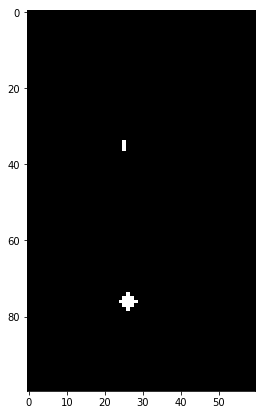

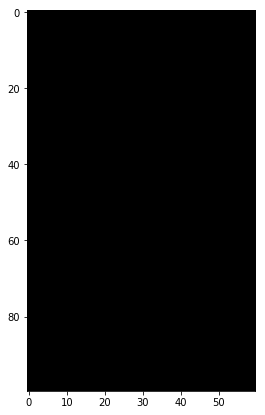

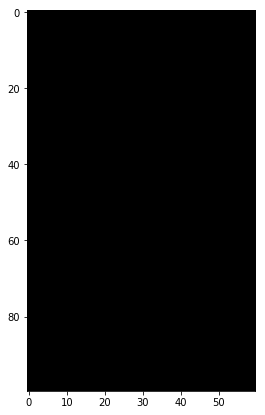

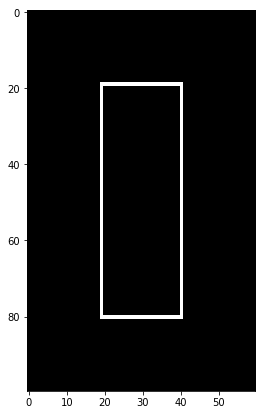

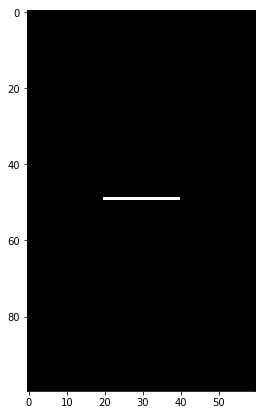

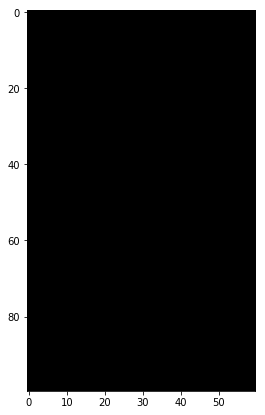

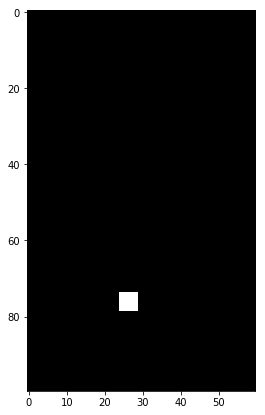

Display Favorability Topology!


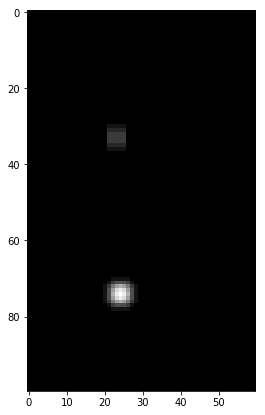

[(74, 24)]


In [5]:
for team, eye in zip(suntzu.teams, suntzu.eyes):
    print("SunTzu is strategist for Team {}.".format(team.name))
    print ("Agent {} ({} {}) is acting as eye for SunTzu.".format(eye.idx, eye.type, eye.role))

print ("Display the Big Picture!")
print (game_space.shape)
for i in range(7):
    plt.figure(figsize=(10, 7))
    plt.imshow(game_space[0,i,:,:])
    plt.show()

print ("Display Favorability Topology!") 
plt.figure(figsize=(10, 7))
plt.imshow(topology)
plt.show()

print (goals)

# Train Team directed by Strategist

A strategist can direct 1 team with a drone agent, which acts as the "eye" for the strategist. The strategist access the game space through the complete obs space of a drone agent.

The code below run training on 1 teams of 1 drone leader and 5 crawler followers. The strategist takes in the game space provided by its eye (drone leader) and assign a goal to the team in the form of a target coordinate. The Team class takes this goal ("move the team to this coordinate") and generate the mission reward such that its drone leader learns to move to that coordinate, while taking as many of crawler followers along.

The trainings of the drone leader and the crawler followers take place separately in [Drone_Leaders.ipynb](Drone_Leaders.ipynb) and [Crawler_Followers.ipynb](Crawler_Followers.ipynb).


## Game Play (1 Team with 1 Drone Leader + 5 Followers)

In [21]:
from torch.autograd import Variable

game = 'Crossing'
map_name = "food_d37_river_w1_d25"
# map_name "food_d37"
# map_name = "food_d37_river_w1_d25_v2"

# device = torch.device('cpu')   # for playing a game on the cpu-only laptop
device = torch.device('cuda')   # for playing a game on the gpu-PC

# Data structure for AI agents (agents will form their own Class later on)
agents = []
actions = []
tags = []

# Set up parameters of agents and teams as inputs into CrossingEnv

scenario = 3
droneleader_dir = droneleader_fc64_models[scenario-1]
scenario = 17
# crawlers_dir = crawler_models[scenario-1]
crawlers_dir = crawler_models[scenario-1]

teams_params = [
        {'name': 'Vikings', 'color': 'deepskyblue', 
         'culture': {'name':'pacifist_leadfollow','laser_penalty':-1.0,'target_reward':2.0},
         'roles': ['leader','follower'],
         'target_zone': None, 'banned_zone': None}        
]

"""
scenario = 17
agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (1,7), 'model': droneleader_dir+'MA0_Crossing_ep2000.p'},
        {'id': 1, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,9), 'model': crawlers_dir+'MA1_Crossing_ep1000.p'},
        {'id': 2, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (2,8), 'model': crawlers_dir+'MA2_Crossing_ep1000.p'},
        {'id': 3, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,7), 'model': crawlers_dir+'MA3_Crossing_ep1000.p'},
        {'id': 4, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,9), 'model': crawlers_dir+'MA4_Crossing_ep1000.p'},
        {'id': 5, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (4,8), 'model': crawlers_dir+'MA5_Crossing_ep1000.p'}
]

agents_params = [  # Best
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (1,7), 'model': droneleader_dir+'MA0_Crossing_ep2000.p'},
        {'id': 1, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,9), 'model': crawlers_dir+'MA5_Crossing_ep1000.p'},
        {'id': 2, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (2,8), 'model': crawlers_dir+'MA5_Crossing_ep1000.p'},
        {'id': 3, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,7), 'model': crawlers_dir+'MA5_Crossing_ep1000.p'},
        {'id': 4, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,9), 'model': crawlers_dir+'MA5_Crossing_ep1000.p'},
        {'id': 5, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (4,8), 'model': crawlers_dir+'MA5_Crossing_ep1000.p'}
]

scenario = 20
agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (1,7), 'model': droneleader_dir+'MA0_Crossing_ep2000.p'},
        {'id': 1, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,9), 'model': crawlers_dir+'MA1_Crossing_ep2000.p'},
        {'id': 2, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (2,8), 'model': crawlers_dir+'MA2_Crossing_ep2000.p'},
        {'id': 3, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,7), 'model': crawlers_dir+'MA3_Crossing_ep2000.p'},
        {'id': 4, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,9), 'model': crawlers_dir+'MA4_Crossing_ep2000.p'},
        {'id': 5, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (4,8), 'model': crawlers_dir+'MA5_Crossing_ep2000.p'}
]

scenario = 14
agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (1,7), 'model': droneleader_dir+'MA0_Crossing_ep2000.p'},
        {'id': 1, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,9), 'model': crawlers_dir+'MA0_Crossing_ep1500.p'},
        {'id': 2, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (2,8), 'model': crawlers_dir+'MA1_Crossing_ep1500.p'},
        {'id': 3, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,7), 'model': crawlers_dir+'MA2_Crossing_ep1500.p'},
        {'id': 4, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,9), 'model': crawlers_dir+'MA3_Crossing_ep1500.p'},
        {'id': 5, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (4,8), 'model': crawlers_dir+'MA4_Crossing_ep1500.p'}
]

agents_params = [  # Best
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (1,7), 'model': droneleader_dir+'MA0_Crossing_ep2000.p'},
        {'id': 1, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,9), 'model': crawlers_dir+'MA1_Crossing_ep1500.p'},
        {'id': 2, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (2,8), 'model': crawlers_dir+'MA1_Crossing_ep1500.p'},
        {'id': 3, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,7), 'model': crawlers_dir+'MA1_Crossing_ep1500.p'},
        {'id': 4, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,9), 'model': crawlers_dir+'MA1_Crossing_ep1500.p'},
        {'id': 5, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (4,8), 'model': crawlers_dir+'MA1_Crossing_ep1500.p'}
]
"""

agents_params = [
        {'id': 0, 'team': 'Vikings', 'color': 'royalblue', 'type': 'drone',    \
         'role': 'leader', 'start': (1,7), 'model': droneleader_dir+'MA0_Crossing_ep2000.p'},
        {'id': 1, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (1,9), 'model': crawlers_dir+'MA5_Crossing_ep1000.p'},
        {'id': 2, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (2,8), 'model': crawlers_dir+'MA5_Crossing_ep1000.p'},
        {'id': 3, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,7), 'model': crawlers_dir+'MA5_Crossing_ep1000.p'},
        {'id': 4, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (3,9), 'model': crawlers_dir+'MA5_Crossing_ep1000.p'},
        {'id': 5, 'team': 'Vikings', 'color': teams_params[0]['color'], 'type': 'crawler',    \
         'role': 'follower', 'start': (4,8), 'model': crawlers_dir+'MA5_Crossing_ep1000.p'}
]

num_agents = len(agents_params)


# Initialize environment
render = True
SPEED = 1/30
num_crawler_actions = 8                       # Crawlers are capable of 8 actions
num_drone_actions = 12                       # Drones are capable of 12 actions
num_goal_params = 2       # 2 parameters in Goal (delta coordinates)

# Initialize constants
num_frames = 7
max_episodes = 1
max_frames = 300

# Initialize parameters for Crossing and Explore
river_penalty = -1
crossed = [0 for i in range(num_agents)]  # Keep track of agents gathering from 2nd food pile
second_pile_x = 50   # x-coordinate of the 2nd food pile
jumping_zone = True

# Load models for AI agents
agents= [[] for i in range(num_agents)]

for i, agent_param in enumerate(agents_params):
    model_file = agent_param['model']
    try:
        with open(model_file, 'rb') as f:         
            if agents_params[i]['type'] is 'drone' and agents_params[i]['role'] is 'leader':
                print("Load Drone Leader.")
                agent = DroneLeader_FC64(num_goal_params, num_drone_actions, i)
            elif agents_params[i]['type'] is 'crawler':
                print("Load saved model for agent {}".format(i))
                agent = Crawler_Policy(num_frames, num_crawler_actions, i)
            else:
                raise Exception('Unexpected agent type: {}'.format(agents_params[i]['type']))
                    
            optimizer = optim.Adam(agent.parameters(), lr=0.1)

            # New way to save and load models - based on: 
            # https://pytorch.org/tutorials/beginner/saving_loading_models.html
            _ = load_model(agent, optimizer, f, device=device)
            agent.eval()
            agents[i] = agent
    except OSError:
        print('Model file not found.')
        raise

# Initialize AI and random agent data
actions = [0 for i in range(num_agents)]
tags = [0 for i in range(num_agents)]

# Attach agents to their teams
# 4-28-2019 Add roles and types to enable multi-role teams

teams = []

# Team Vikings
agents_list = [agents[0], agents[1],agents[2],agents[3],agents[4],agents[5]]
teams.append(Team(name=teams_params[0]['name'],color=teams_params[0]['color'],culture=teams_params[0]['culture'], \
                  roles=teams_params[0]['roles'], \
                  agent_policies=agents_list, \
                  agent_roles = [agent['role'] for agent in agents_params[0:len(agents_list)]]))

# 5-29-2019  Strategist accepts directorship of a team
suntzu = Strategist()
suntzu.accept(teams[0])   # Strategist accepts directorship of Team Viking

env = CrossingEnv(agents=agents_params, teams=teams_params, \
                  map_name=map_name, river_penalty=river_penalty,  \
                  debug_window = True, debug_agent=1)   

for ep in range(max_episodes):
    
    US_hits = [0 for i in range(num_agents)]
    THEM_hits = [0 for i in range(num_agents)]

    env_obs = env.reset()  # Environment return observations
    """
    # For Debug only
    print (len(agents_obs))
    print (agents_obs[0].shape)
    """
    
    # Unpack observations into data structure compatible with agent Policy
    agents_obs = unpack_env_obs(env_obs)
    
    # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
    game_space = agents_obs[suntzu.eyes[0].idx]
    goals, topology = suntzu.generate_goals(game_space)
    deltas = calc_deltas(goals[0], env.agent_locations[0])
        
    for i in range(num_agents):    # Reset agent info - e.g. laser tag statistics
        agents[i].reset_info()    
    
    env.render()  
    time.sleep(SPEED)  # Change speed of video rendering
    
    """

    """
    # For Debug only
    # print (len(agents_obs))
    # print (agents_obs[0].shape)    
    
    """
    For now, we do not stack observations, and we do not implement LSTM
    
    state = np.stack([state]*num_frames)

    # Reset LSTM hidden units when episode begins
    cx = Variable(torch.zeros(1, 256))
    hx = Variable(torch.zeros(1, 256))
    """

    for frame in range(max_frames):

        for i, agent_param in enumerate(agents_params):
            if agent_param['type'] is 'drone' and agent_param['role'] is 'leader':
                # 6-02-2019 Simple droneleaders do not require obs space as input
                actions[i], _ = select_action_strat_simple(agents[i], deltas, cuda=False)
            else:    
                actions[i], _ = select_action(agents[i], agents_obs[i], cuda=False)
            
            # Only crawlers can fire lasers
            if agent_param['type'] is 'crawler':
                if actions[i] is 6:  # action[i] is a tensor, .item() returns the integer
                    tags[i] += 1   # record a tag for accessing aggressiveness
                
        """
        For now, we do not implement LSTM
        # Select action
        action, log_prob, state_value, (hx,cx)  = select_action(model, state, (hx,cx))        
        """

        # if frame % 10 == 0:
        #     print (actions)    
        
        # Perform step        
        env_obs, reward, done, info = env.step(actions)
        
        """
        For Debug only
        print (env_obs)
        print (reward)
        print (done) 
        """

        for i in range(num_agents):
            agents[i].rewards.append(reward[i])  # Stack rewards

        
        # Unpack observations into data structure compatible with agent Policy
        agents_obs = unpack_env_obs(env_obs)
        load_info(agents, agents_params, info, narrate=False)   # Load agent info for AI agents
        
        # 5-29-2019 Strategist uses the obs space of its team eye as the big picture
        game_space = agents_obs[suntzu.eyes[0].idx]
        goals, topology = suntzu.generate_goals(game_space)
        deltas = calc_deltas(goals[0], env.agent_locations[0])        
        
        for i, agent_param in enumerate(agents_params):
            # Only crawlers can fire lasers
            if agent_param['type'] is 'crawler':            
                US_hits[i] += agents[i].US_hit
                THEM_hits[i] += agents[i].THEM_hit
            
        """
        For now, we do not stack observation, may come in handy later on
        
        # Evict oldest diff add new diff to state
        next_state = np.stack([next_state]*num_frames)
        next_state[1:, :, :] = state[:-1, :, :]
        state = next_state
        """
         
        total = 0
        for i in range(num_agents):
            agent_reward = sum(agents[i].rewards)
            total += agent_reward
        
        if render:
            env.render()
            time.sleep(SPEED)  # Change speed of video rendering        

        if any(done):
            print("Done after {} frames".format(frame))
            break

env.close()  # Close the rendering window

# Print out statistics of AI agents

total_rewards = 0
total_tags = 0
total_US_hits = 0
total_THEM_hits = 0

print ('\nStatistics by Agent')
print ('===================')
for i, agent_param in enumerate(agents_params):
    agent_reward = sum(agents[i].rewards)
    total_rewards += agent_reward
    print ("Agent{} reward is {:d}".format(i, agent_reward))
    
    # Only crawlers can fire lasers
    if agent_param['type'] is 'crawler':     
        agent_tags = sum(agents[i].tag_hist)
        total_tags += agent_tags
        # print ("Agent{} aggressiveness is {:.2f}".format(i, sum(agents[i].tag_hist)/(frame+1e-7)))
 
        agent_US_hits = sum(agents[i].US_hits)
        agent_THEM_hits = sum(agents[i].THEM_hits)
        total_US_hits += agent_US_hits
        total_THEM_hits += agent_THEM_hits

        # print('US agents hit = {}'.format(agent_US_hits))
        # print('THEM agents hit = {}'.format(agent_THEM_hits ))

print ('\nStatistics in Aggregate')
print ('=======================')
print ('Total rewards gathered = {}'.format(total_rewards))
num_crawlers = sum([1 if param['type'] is 'crawler' else 0 for param in agents_params])
print ('Av. rewards per agent = {0:.2f}'.format(total_rewards/num_crawlers))
# print ('Num laser fired = {}'.format(total_tags))
# print ('Total US Hit (friendly fire) = {}'.format(total_US_hits))
# print ('Total THEM Hit = {}'.format(total_THEM_hits))
# print ('friendly fire (%) = {0:.3f}'.format(total_US_hits/(total_US_hits+total_THEM_hits+1e-7)))

# 6-02-2019 Update distance from goal for droneleader
target_x, target_y = goals[0]
current_x, current_y = env.agent_locations[0]
episode_delta = abs(target_x - current_x) + abs(target_y - current_y)
print ('DroneLeader Distance from Goal = {}'.format(episode_delta))

for (i, loc) in env.consumption:
    if loc[0] > second_pile_x:
        # print ('agent {} gathered an apple in 2nd pile'.format(i))
        crossed[i] = 1
        
print ("Num agents gathering from 2nd food pile: {}".format(sum(crossed)))

print ('\nStatistics by Team')
print ('===================')
top_team = None
top_team_reward = 0

for i, team in enumerate(teams):
    if team.name is not 'Crazies':
        reward = sum(team.sum_rewards())
        print ('Team {} has total reward of {}'.format(team.name, reward))
                           
        if reward > top_team_reward:   # Keep track of dominating team
            top_team_reward = reward
            top_team = team.name

# Team dominance calculation
if len(teams) > 1:
    print ('Dominating Team: {}'.format(top_team))
    dominance = top_team_reward/((total_rewards-top_team_reward+1.1e-7)/(len(teams)-1))    
    print ('Team dominance: {0:.2f}x'.format(dominance))


Load Drone Leader.
Load saved model for agent 1
Load saved model for agent 2
Load saved model for agent 3
Load saved model for agent 4
Load saved model for agent 5

Statistics by Agent
Agent0 reward is 0
Agent1 reward is 32
Agent2 reward is 27
Agent3 reward is 4
Agent4 reward is 29
Agent5 reward is 22

Statistics in Aggregate
Total rewards gathered = 114
Av. rewards per agent = 22.80
DroneLeader Distance from Goal = 44
Num agents gathering from 2nd food pile: 4

Statistics by Team
Team Vikings has total reward of 114


In [36]:
env.close()